# Mortgage Modeling: Stochastic Mortgage: Modeling Prepayment

This notebook explains the theoretical background and formulas used in the mortgage-related code (i.e., the functions **Bullet** and **Annuity**). In these models, we simulate how the outstanding mortgage balance evolves over time under scheduled payments, interest, and prepayment behavior.

---

## 1. Mortgage Models Overview

In mortgage modeling, the outstanding notional amount evolves due to:
- **Interest payments:** Periodic payments calculated on the outstanding balance.
- **Scheduled principal repayments:** Pre-determined repayments that reduce the balance.
- **Prepayments:** Extra repayments (unscheduled) that occur when borrowers decide to pay off part of the mortgage earlier. These are often modeled stochastically based on certain incentives.

---

## 2. Bullet Mortgage Model

In a **Bullet** mortgage:
- The borrower pays **interest only** during the term.
- The principal (notional) is repaid in a lump sum at maturity.
- However, prepayments may still occur and reduce the outstanding balance over time.

The formulas used are:

- **Interest Payment at time $t$:**
  $$
  I_t = r \cdot N_{t-1}
  $$
  where:
  - $r$ is the interest rate,
  - $N_{t-1}$ is the outstanding notional at time $t-1$.

- **Scheduled Principal Payment:**
  $$
  Q_t = 0 \quad \text{(for } t < T \text{)}
  $$
  (No scheduled principal repayment until maturity.)

- **Prepayment at time $t$:**
  $$
  P_t = \text{CPR}_t \times N_{t-1}
  $$
  where $\text{CPR}_t$ is the constant prepayment rate (which can be stochastic).

- **Outstanding Notional Update:**
  $$
  N_t = N_{t-1} - Q_t - P_t = N_{t-1} - P_t
  $$

- **Total Installment (Cash Flow) at time $t$:**
  $$
  C_t = I_t + Q_t + P_t = I_t + P_t
  $$
  
At maturity (time $T$), the entire remaining notional is repaid:
  $$
  Q_T = N_{T-1} \quad \text{and} \quad C_T = I_T + N_{T-1}
  $$

---

## 3. Annuity Mortgage Model

In an **Annuity** mortgage:
- The borrower makes equal (or level) installment payments over the term.
- Each installment consists of an interest component and a scheduled principal repayment.
- Prepayments are added on top of the scheduled principal repayments.

The key formulas are:

- **Installment Payment at time $t$:**
  $$
  C_t = \frac{r \cdot N_{t-1}}{1 - (1 + r)^{-m}}
  $$
  where:
  - $m$ is the number of remaining periods,
  - $N_{t-1}$ is the outstanding notional at time $t-1$.

- **Interest Payment:**
  $$
  I_t = r \cdot N_{t-1}
  $$

- **Scheduled Principal Repayment:**
  $$
  Q_t = C_t - I_t
  $$

- **Prepayment:**
  $$
  P_t = \text{CPR}_t \times \left( N_{t-1} - Q_t \right)
  $$

- **Notional Update:**
  $$
  N_t = N_{t-1} - Q_t - P_t
  $$

---

## 4. Stochastic Mortgage: Modeling Prepayment

In practice, prepayments are influenced by many factors. In the code, the prepayment rate is determined by an **incentive function** that depends on the difference between a target rate $K$ and the current swap rate $S(t)$:
  
- Define the **incentive** as:
  $$
  \text{Incentive}(x) = 0.04 + \frac{0.1}{1+\exp\left(200\cdot (-x)\right)}
  $$
  where $x = K - S(t)$.

This function is a sigmoid that captures the idea that when the current rate is below the target ($K - S(t)$ is positive), the borrower has a higher incentive to prepay (possibly to refinance at a lower rate). Conversely, if $S(t)$ is higher, the incentive drops.

The stochastic nature comes from:
- The **swap rate $S(t)$** evolving over time under uncertainty.
- Consequently, the computed **prepayment rate $\text{CPR}_t$** varies stochastically across simulated paths.

In the mortgage models:
- The **Bullet** and **Annuity** functions use the $\text{CPR}_t$ value (possibly different at each time step and path) to adjust the outstanding notional.

---

## 5. Summary

- **Bullet Mortgage:**  
  - No scheduled principal repayment until maturity.
  - Interest and stochastic prepayments reduce the notional over time.
  - Total cash flow is the sum of interest and prepayments, with a lump-sum principal at maturity.

- **Annuity Mortgage:**  
  - Equal installment payments are calculated using the annuity formula.
  - Each installment is split into interest and scheduled principal repayments.
  - Additional prepayments (modeled stochastically) further reduce the outstanding balance.

- **Stochastic Mortgage Component:**  
  - Prepayment rates are not fixed but depend on the dynamic incentive function.
  - This function, driven by the evolving swap rate, captures the borrower's tendency to prepay when market conditions are favorable.

This theoretical framework helps in understanding how different mortgage payment structures behave under uncertainty, which is crucial when building financial models for quantitative analysis.

---


0.0

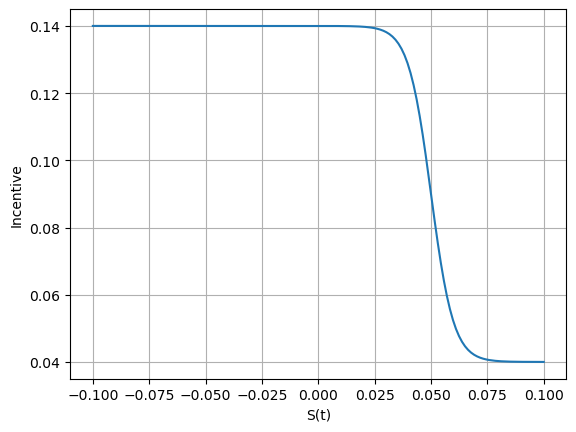

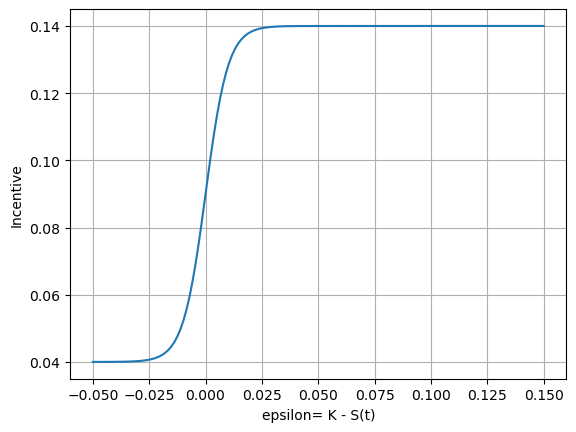

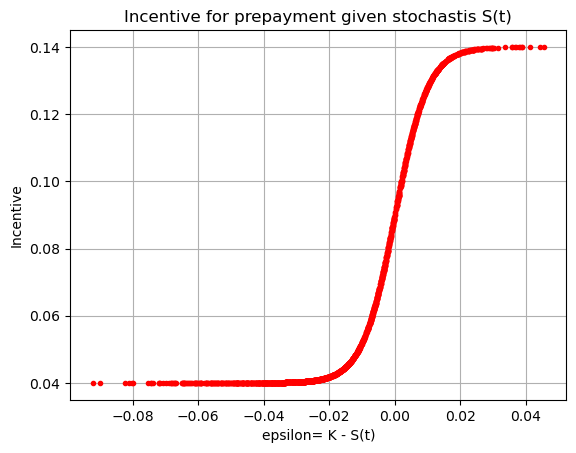

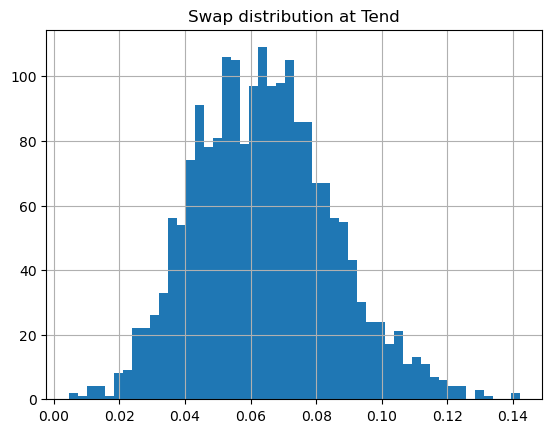

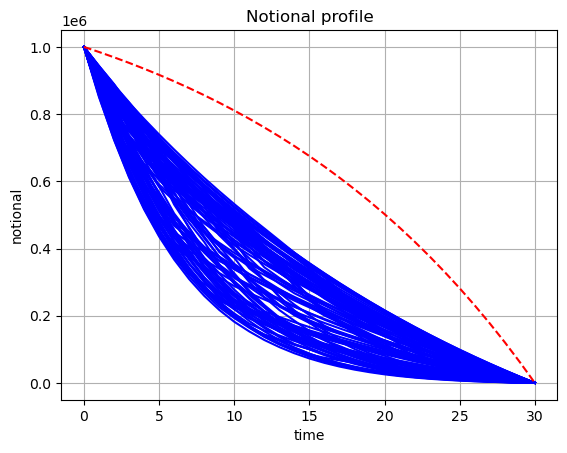

In [1]:
import matplotlib.pyplot as plt

import scipy.integrate as integrate
import numpy as np

def GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T,P0T, lambd, eta):    
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    #theta = lambda t: 0.1 +t -t
    #print("changed theta")
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R}
    return paths

def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta

def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * np.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) 
        
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1)
    else:
        return np.ones([n])

def SwapRateHW(t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(r_t));
    
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)

    swapRate = (P_t_Ti - P_t_Tm) / temp
    
    return swapRate

def Bullet(rate,notional,periods,CPR):
    # it returns a matrix M such that
    # M = [t  notional(t)  prepayment(t)  notional_quote(t)  interest_(t)  installment(t)]
    # WARNING! here "rate" and "periods" are quite general, the choice of getting year/month/day.. steps, depends on the rate
    # that the function receives. So, it is necessary to pass the correct rate to the function
    M = np.zeros((periods + 1,6))
    M[:,0] = np.arange(periods + 1) # we define the times
    M[0,1] = notional
    for t in range(1,periods):
        M[t,4] = rate*M[t-1,1]      # interest quote
        M[t,3] = 0                  # notional quote, 0 for bullet mortgage
        scheduled_oustanding = M[t-1,1] - M[t,3]
        M[t,2] = scheduled_oustanding * CPR[t]    # prepayment
        M[t,1] = scheduled_oustanding - M[t,2] # notional(t) = notional(t-1) - (notional quote + prepayment)
        M[t,5] = M[t,4] + M[t,2] + M[t,3]
        
    M[periods,4] = rate*M[periods-1,1] # interest quote
    M[periods,3] = M[periods-1,1]      # notional quote
    M[periods,5] = M[periods,4] + M[periods,2] + M[periods,3]
    return M    

def Annuity(rate,notional,periods,CPR):
    # it returns a matrix M such that
    # M = [t  notional(t)  prepayment(t)  notional_quote(t)  interest_quote(t)  installment(t)]
    # WARNING! here "rate" and "periods" are quite general, the choice of getting year/month/day.. steps, depends on the rate
    # that the function receives. So, it is necessary to pass the correct rate to the function
    M = np.zeros((periods + 1,6))
    M[:,0] = np.arange(periods + 1) # we define the times
    M[0,1] = notional
    for t in range(1,periods + 1):
        # we are computing the installment at time t knowing the oustanding at time (t-1)
        remaining_periods = periods - (t - 1)  
        
        # Installment, C(t_i) 
        M[t,5] = rate * M[t-1,1]/(1 - 1/(1 + rate)**remaining_periods) 
        
        # Interest rate payment, I(t_i) = r * N(t_{i})
        M[t,4] = rate * M[t-1,1] 
        
        # Notional payment, Q(t_i) = C(t_i) - I(t_i)
        M[t,3] = M[t,5] - M[t,4] 
        
        # Prepayment, P(t_i)= Lambda * (N(t_i) -Q(t_i))
        M[t,2] = CPR[t] * (M[t-1,1] - M[t,3]) 
        
        # notional, N(t_{i+1}) = N(t_{i}) - lambda * (Q(t_{i} + P(t_i)))
        M[t,1] = M[t-1,1] - M[t,3] - M[t,2] 
    return M

def mainCode():
    # incentive function
    Irrational = lambda x : 0.04 + 0.1/(1 + np.exp(200 * (-x))) 
    Rational   = lambda x : 0.04*(x>0.0)

    
    IncentiveFunction = Irrational
    
    K = 0.05
    newRate = np.linspace(-0.1,0.1,150)
    
    epsilon = K - newRate
    incentive = IncentiveFunction(epsilon)
    
    plt.figure(1)
    plt.plot(newRate,incentive)
    plt.xlabel('S(t)')
    plt.ylabel('Incentive')
    plt.grid()
    
    plt.figure(2)
    plt.plot(epsilon,incentive)
    plt.xlabel('epsilon= K - S(t)')
    plt.ylabel('Incentive')
    plt.grid()
    
    NoOfPaths = 2000
    NoOfSteps = 30
    lambd     = 0.05
    eta       = 0.01
    
    Tend = 30
    
    P0T=lambda T:np.exp(-0.05*T)
    paths=GeneratePathsHWEuler(NoOfPaths, NoOfSteps, Tend, P0T, lambd, eta)
    R = paths["R"]

    tiGrid = paths["time"]
    # computing swap rate at point of assmuming
    S=np.zeros([NoOfPaths,NoOfSteps+1])
    for (i,ti) in enumerate(tiGrid):
        S[:,i]=SwapRateHW(ti, ti, Tend+ti, 30, R[:,i], P0T, lambd, eta)
        
    # inenctive of nrew swap
    epsilon=K-S[:,-1]
    incentive=IncentiveFunction(epsilon)
    plt.figure(3)
    plt.plot(epsilon,incentive,'.r')
    plt.xlabel('epsilon= K - S(t)')
    plt.ylabel('Incentive')
    plt.grid()
    plt.title('Incentive for prepayment given stochastis S(t)')
    
    plt.figure(4)
    plt.hist(S[:,-1],bins=50)
    plt.grid()
    plt.title('Swap distribution at Tend')
    
    MortgageProfile =  Annuity
    notional = 1000000
    N = np.zeros([NoOfPaths,NoOfSteps+1])
    
    for i in range(0,NoOfPaths):
        epsilon =  K - S[i,:]
        Lambda = IncentiveFunction(epsilon)
        NotionalProfile = MortgageProfile(K,notional,NoOfSteps,Lambda)
        N[i,:] = NotionalProfile[:,1]

    plt.figure(6)
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('notional')
    
    n = 100
    for k in range(0,n):
        plt.plot(tiGrid,N[k,:],'-b')
    
    AnnuityProfile_NoPrepayment = MortgageProfile(K,notional,NoOfSteps,np.zeros(NoOfSteps+1))
    plt.plot(tiGrid,AnnuityProfile_NoPrepayment[:,1],'--r')
    plt.title('Notional profile')
        
    return 0.0



mainCode()
    
    
    